In [1]:
#pip install holidays

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays
import os

from math import sqrt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from sklearn import datasets, linear_model

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
atl_v = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/nyc_violent_final copy.csv", parse_dates=['date'])
atl_temp = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/ISYE6203_ATL_avg_temp_2009-2020.csv", parse_dates=['date'])
holiday = pd.read_csv("/Users/sameshbajaj/Desktop/Time Series Analysis/Assignments/Project/Holidays_2009-2020.csv", parse_dates=['date'])

In [4]:
atl_v = atl_v.set_index("date")
atl_temp = atl_temp.set_index("date")
holiday = holiday.set_index("date")

<AxesSubplot:xlabel='date'>

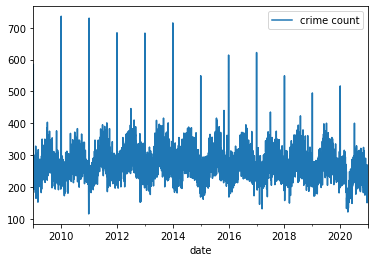

In [5]:
atl_v.plot()

In [6]:
atl_temp

,avgTemp
date,
2009-01-01,37.94
2009-01-02,43.52
2009-01-03,51.98
2009-01-04,59.45
2009-01-05,62.42
...,...
2020-12-27,43.52
2020-12-28,47.03
2020-12-29,52.52


<AxesSubplot:xlabel='date'>

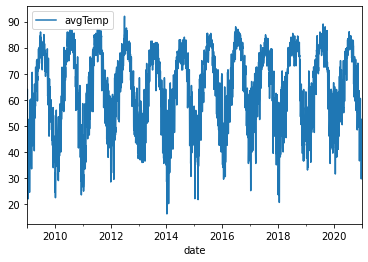

In [7]:
atl_temp.plot()

In [8]:
holiday

,Holiday
date,
2009-01-01,1
2009-01-02,0
2009-01-03,0
2009-01-04,0
2009-01-05,0
...,...
2020-12-27,0
2020-12-28,0
2020-12-29,0


In [9]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [10]:
test_stationarity(atl_v)

Results of Dickey-Fuller Test:
Test Statistic                   -4.165
p-value                           0.001
#Lags Used                       28.000
Number of Observations Used    4354.000
Critical Value (1%)              -3.432
Critical Value (5%)              -2.862
Critical Value (10%)             -2.567
dtype: float64


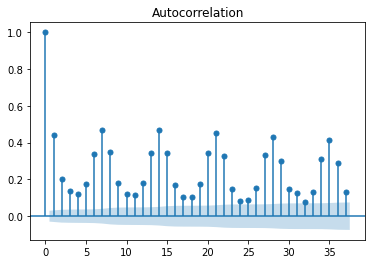

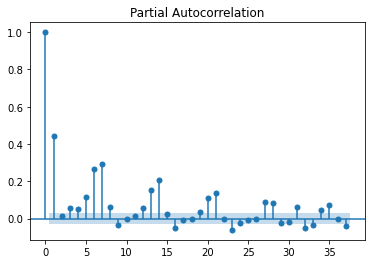

In [11]:
acf=plot_acf(atl_v)
pacf=plot_pacf(atl_v)

<AxesSubplot:xlabel='date'>

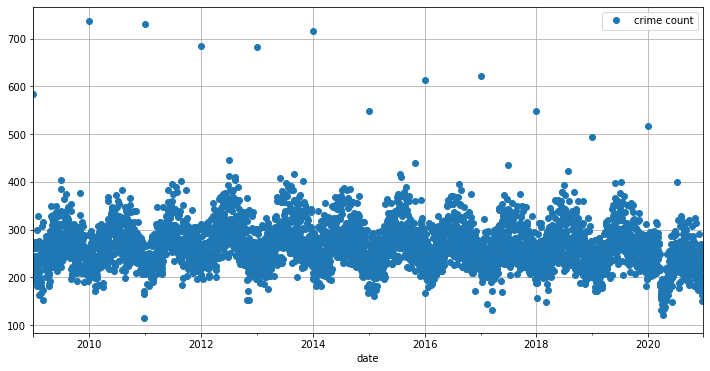

In [12]:
train_end = '2020-12-24'
#test_start = '2020-12-18'
test_end = '2020-12-31'
demo_start = '2020-10-31'
demo = atl_v[demo_start:test_end]
atl_v_train, atl_v_test = atl_v[:train_end], atl_v[train_end:]

atl_v_train.plot(figsize=(12,6), style='o', grid=True)

In [13]:
begin = '2009-01-01'
abv = '2020-12-30'

exo = holiday.copy()
exo_train,exo_test = exo[:train_end], exo[train_end:abv]
exo_test

,Holiday
date,
2020-12-24,1
2020-12-25,1
2020-12-26,0
2020-12-27,0
2020-12-28,0
2020-12-29,0
2020-12-30,0


In [14]:
exo_train.shape

(4376, 1)

In [15]:
exo_test.shape

(7, 1)

In [16]:
atl_v_train.shape

(4376, 1)

In [17]:
atl_v_test.shape

(8, 1)

In [18]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [19]:
# set parameter range
p,d,q = range(0,2),[1],range(0,2)
P,D,Q,s = range(0,2),[1],range(0,2),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

In [20]:
all_res = sarimax(atl_v_train,exo_train,all_param)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22184D+00    |proj g|=  2.43173D-04

At iterate    5    f=  5.53744D+00    |proj g|=  2.06413D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     25      1     0     0   2.064D-07   5.537D+00
  F =   5.5374431809754681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:48467.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.



At iterate    5    f=  5.21298D+00    |proj g|=  8.39337D-04

At iterate   10    f=  5.21165D+00    |proj g|=  8.79776D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   8.798D-06   5.212D+00
  F =   5.2116495076923082     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:45618.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38855D+00    |proj g|=  3.44908D-03


 This problem is unconstrained.



At iterate    5    f=  5.38852D+00    |proj g|=  2.72863D-03

At iterate   10    f=  5.38836D+00    |proj g|=  3.31521D-04

At iterate   15    f=  5.38827D+00    |proj g|=  7.41747D-03

At iterate   20    f=  5.38779D+00    |proj g|=  1.23903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   5.150D-06   5.388D+00
  F =   5.3877863885427608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:47159.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  5.23460D+00    |proj g|=  1.10382D-02

At iterate   10    f=  5.21227D+00    |proj g|=  1.67368D-03

At iterate   15    f=  5.21152D+00    |proj g|=  2.92045D-05

At iterate   20    f=  5.21149D+00    |proj g|=  1.17294D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   2.158D-06   5.211D+00
  F =   5.2114906345399454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:45618.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  5.29381D+00    |proj g|=  1.47924D-03

At iterate   10    f=  5.28605D+00    |proj g|=  3.03202D-04

At iterate   15    f=  5.28581D+00    |proj g|=  2.01774D-04

At iterate   20    f=  5.28561D+00    |proj g|=  4.03464D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     22      1     0     0   5.206D-06   5.286D+00
  F =   5.2855980901280120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:46265.55


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14855D+00    |proj g|=  5.39575D-02

At iterate    5    f=  4.99687D+00    |proj g|=  2.23666D-02

At iterate   10    f=  4.98116D+00    |proj g|=  2.21524D-03

At iterate   15    f=  4.97400D+00    |proj g|=  5.50698D-04

At iterate   20    f=  4.97397D+00    |proj g|=  2.11537D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   2.115D-06   4.974D+00
  F =   4.9739681715175790     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.17340D+00    |proj g|=  6.00735D-03

At iterate   10    f=  5.13389D+00    |proj g|=  4.93093D-03

At iterate   15    f=  5.13348D+00    |proj g|=  4.97475D-04

At iterate   20    f=  5.13308D+00    |proj g|=  4.82187D-04

At iterate   25    f=  5.13299D+00    |proj g|=  3.12452D-04

At iterate   30    f=  5.13297D+00    |proj g|=  3.69527D-04

At iterate   35    f=  5.13297D+00    |proj g|=  3.21235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     44      1     0     0   4.765D-05   5.133D+00
  F =   5.1329656603811245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.08685D+00    |proj g|=  9.80863D-03

At iterate   10    f=  4.98162D+00    |proj g|=  1.55693D-03

At iterate   15    f=  4.97720D+00    |proj g|=  2.45935D-02

At iterate   20    f=  4.97403D+00    |proj g|=  8.95934D-05

At iterate   25    f=  4.97399D+00    |proj g|=  7.06541D-04

At iterate   30    f=  4.97379D+00    |proj g|=  3.38772D-04

At iterate   35    f=  4.97378D+00    |proj g|=  6.20508D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   6.205D-06   4.974D+00
  F =   4.9737817755275602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.43839D+00    |proj g|=  3.55558D-03

At iterate   10    f=  5.43799D+00    |proj g|=  3.13052D-03

At iterate   15    f=  5.43795D+00    |proj g|=  3.50949D-03

At iterate   20    f=  5.43720D+00    |proj g|=  1.41291D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   6.475D-06   5.437D+00
  F =   5.4368595428131226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 7) - AIC:47589.39


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22484D+00    |proj g|=  4.19872D-02

At iterate    5    f=  5.17980D+00    |proj g|=  7.91119D-03

At iterate   10    f=  5.11004D+00    |proj g|=  3.98929D-03

At iterate   15    f=  5.10950D+00    |proj g|=  2.26383D-02

At iterate   20    f=  5.10901D+00    |proj g|=  9.32794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   2.832D-06   5.109D+00
  F =   5.1090103784744159     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.30264D+00    |proj g|=  4.77012D-02

At iterate   10    f=  5.28601D+00    |proj g|=  3.64480D-03

At iterate   15    f=  5.28597D+00    |proj g|=  4.55381D-03

At iterate   20    f=  5.28349D+00    |proj g|=  3.56554D-02

At iterate   25    f=  5.28070D+00    |proj g|=  4.03951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   8.253D-06   5.281D+00
  F =   5.2806972226843651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 7) - AIC:46224.66


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25522D+00    |proj g|=  7.90822D-02

At iterate    5    f=  5.19998D+00    |proj g|=  2.52765D-02

At iterate   10    f=  5.11613D+00    |proj g|=  3.95653D-03

At iterate   15    f=  5.11590D+00    |proj g|=  1.01526D-02

At iterate   20    f=  5.11153D+00    |proj g|=  2.76756D-02

At iterate   25    f=  5.11011D+00    |proj g|=  7.07185D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.29358D+00    |proj g|=  1.07707D-02

At iterate   10    f=  5.27499D+00    |proj g|=  2.42665D-03

At iterate   15    f=  5.27303D+00    |proj g|=  1.34728D-03

At iterate   20    f=  5.27231D+00    |proj g|=  7.55929D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   7.559D-07   5.272D+00
  F =   5.2723081213864846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(0, 1, 0, 7) - AIC:46151.24


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13842D+00    |proj g|=  5.91917D-02

At iterate    5    f=  5.07715D+00    |proj g|=  1.19592D-02

At iterate   10    f=  4.97478D+00    |proj g|=  3.04217D-02

At iterate   15    f=  4.97322D+00    |proj g|=  1.96061D-03

At iterate   20    f=  4.97111D+00    |proj g|=  2.46432D-02

At iterate   25    f=  4.96804D+00    |proj g|=  2.48417D-04

At iterate   30    f=  4.96803D+00    |proj g|=  2.05504D-04

At iterate   35    f=  4.96788D+00    |proj g|=  1.75425D-03

At iterate   40    f=  4.96778D+00    |proj g|=  1.35219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.18167D+00    |proj g|=  3.94353D-02

At iterate   10    f=  5.12712D+00    |proj g|=  1.58490D-02

At iterate   15    f=  5.12532D+00    |proj g|=  2.10123D-03

At iterate   20    f=  5.12471D+00    |proj g|=  2.37085D-03

At iterate   25    f=  5.12088D+00    |proj g|=  1.60708D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   2.166D-05   5.121D+00
  F =   5.1208799945582344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 1)x(1, 1, 0, 7) - AIC:44827.94
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  5.09802D+00    |proj g|=  2.51438D-02

At iterate   10    f=  5.01910D+00    |proj g|=  6.39911D-02

At iterate   15    f=  4.98696D+00    |proj g|=  1.27453D-01

At iterate   20    f=  4.97335D+00    |proj g|=  5.62034D-04

At iterate   25    f=  4.97312D+00    |proj g|=  7.23676D-03

At iterate   30    f=  4.96890D+00    |proj g|=  1.74011D-02

At iterate   35    f=  4.96804D+00    |proj g|=  1.07861D-04

At iterate   40    f=  4.96803D+00    |proj g|=  8.32648D-04

At iterate   45    f=  4.96792D+00    |proj g|=  6.74167D-03

At iterate   50    f=  4.96779D+00    |proj g|=  2.33134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [21]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7c1062afd0>,
  43488.05206145358,
  ((1, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7c1065dbb0>,
  43490.066266203095,
  ((1, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7c476553a0>,
  43540.16943712185,
  ((0, 1, 1), (0, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7c3669c4c0>,
  43540.53809941721,
  ((0, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f7c2bf28c10>,
  44722.05883240809,
  ((1, 1, 0), (0, 1, 1, 7)))]

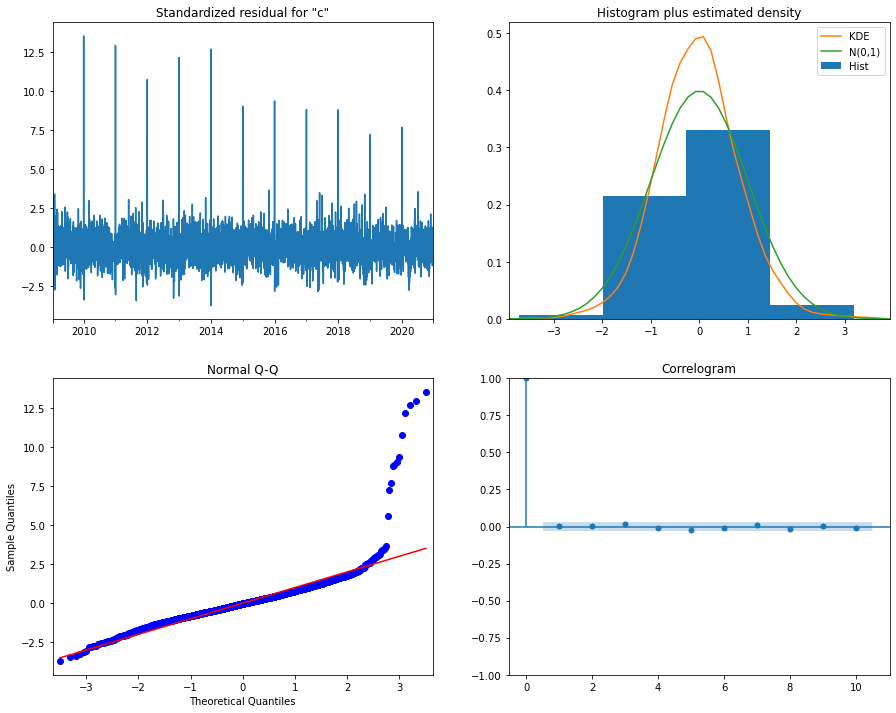

Ljung-box p-values:
[0.69994331 0.84202251 0.6679371  0.75387406 0.5993541  0.6934071
 0.70669597 0.68991637 0.76823525 0.81844624 0.81368502 0.86782989
 0.88601249 0.0341105 ]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       crime count   No. Observations:                 4376
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -21739.026
Date:                           Tue, 26 Apr 2022   AIC                          43488.052
Time:                                   22:06:15   BIC                          43519.962
Sample:                               01-01-2009   HQIC                         43499.313
                                    - 12-24-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       36.8195      2.051     17.951      0.000      32.799      40.840
ar.L1          0.1234      0.010     11.874      0.000       0.103       0.144
ma.L1         -0.9251      0.007   -137.641      0.000      -0.938      -0.912
ma.S.L7       -0.9922      0.003   -386.903      0.000      -0.997      -0.987
sigma2      1222.3217     11.149    109.633      0.000    1200.470    1244.174
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):            226742.88
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             3.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

In [23]:
def pm(y_true, y_pred):
    return sum((y_true-y_pred)**2)/sum((y_true-np.mean(y_true))**2)

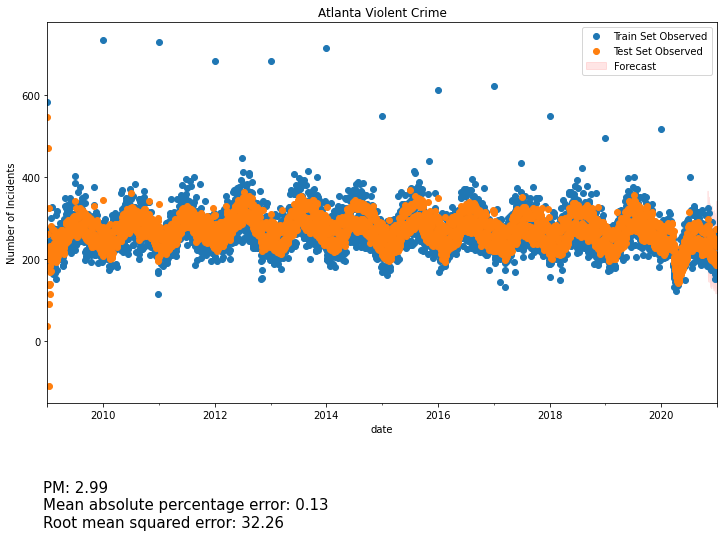

In [24]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])



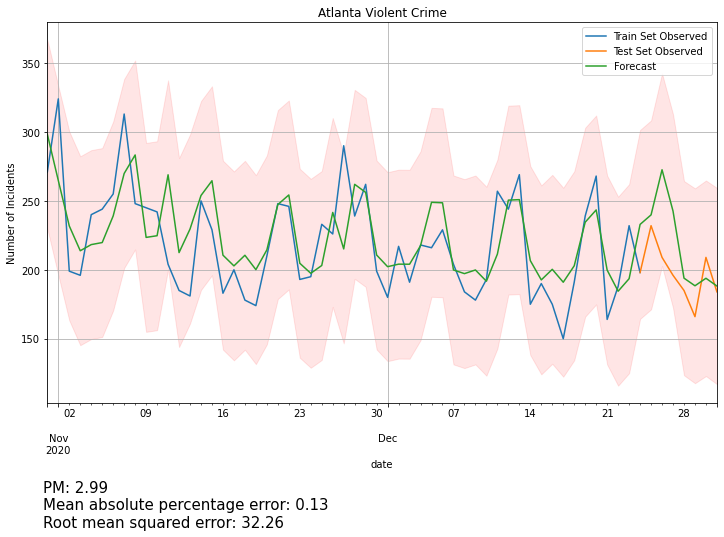

In [25]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = ('\nPM: %.2f'% pm(atl_v_test['crime count'], pred_test.predicted_mean.to_frame()['predicted_mean']) + \
      '\nMean absolute percentage error: %.2f'% MAPE(atl_v_test, pred_test.predicted_mean) + \
      '\nRoot mean squared error: %.2f'% sqrt(MSE(atl_v_test, pred_test.predicted_mean)))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Atlanta Violent Crime', ylabel='Number of Incidents')

atl_v_train[demo_start:].plot(ax=ax)
atl_v_test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)